# Análise de sobrevivência do período ativo dos CNPJ's das entidades empresariais do Piauí

In [46]:
# loading package
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import autograd.numpy as np


from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import (WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter)
from lifelines.plotting import qq_plot

from IPython.display import Image

# configure
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# configure chats
# setting of the graphics 
from matplotlib import rc
# estilo dos gráficos #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('Solarize_Light2')
%config InlineBackend.figure_format = 'retina'  # image format
rc('font', **{"family":"sans-serif","sans-serif":["DejaVu Sans"], "size":10})

rc('mathtext', **{"default":"regular"})

import warnings
warnings.filterwarnings("ignore")

#configure out of pandas dataframe
pd.options.display.max_colwidth = 150

## Algumas explicações


A análise de sobrevivência é um método estatístico que busca estimar o tempo até a ocorrência de um evento de interesse, chamado de falha. Um exemplo comum de aplicação da análise de sobrevivência é na área da saúde, onde se quer saber qual é a expectativa de vida de um paciente com um determinado tipo de câncer.

Neste estudo, vamos explorar a duração do período ativo dos CNPJs no Piauí. Os dados foram coletados do site da Receita Federal, disponíveis no seguinte link: `https://www.gov.br/receitafederal/pt-br/acesso-a-informacao/dados-abertos`.


Assim, levamos em conta a data de ativação do CNPJ da empresa e determinamos o número de anos até a data de encerramento do CNPJ, conforme registrado no banco de dados.

Podemos inferir que a variável de interesse em nossa análise é o tempo. As variáveis que serão analisadas são as características do elemento em estudo. Por exemplo, no caso de um paciente com C.A., consideramos fatores como sexo, idade e raça. No contexto das empresas, a variável principal é o *tipo de atividade principal* exercida pela empresa. Além disso, tentou-se utilizar a localização da empresa, seja no interior ou na capital.

Nos últimos tempos, com a evolução dos modelos de análise multivariada, com análises com várias variáveis. No caso desta análise, somente a região se mostrou utilizável, mas não necessária. Para os casos com a presença de variáveis, há modelos de regressão de sobrevivência  e a loft realizou o trabalho de reunir a análise de sobrevivência com algoritmo de Xgboost que pode ser vista aqui: xgbse: Análise de Sobrevivência robusta e eficiente em Python | by Davi Vieira | Loft | Medium. Outro modelo de deep learning pode ser visto em https://github.com/jaredleekatzman/DeepSurv.

E quanto às CNPJ's que ainda ativos, mesmo após o fim fo período de análise? Elas são incluídas na pesquisa como censuradas, fazendo parte da população que não experimentou falha. No entanto, elas são consideradas através do método de construção de distribuição `Kapler Meier`, que utiliza a Máxima Verossimilhança levando em conta a existência de censuras e falhas.

A função principal que vamos utilizar é a função de sobrevivência, denotada por $S(t) = P(T > t)$. Esta é *definida como a probabilidade de uma observação persistir sem falhar até um determinado tempo t*. Por exemplo, quando expressamos $S(5)$, estamos buscando entender a probabilidade do objeto em estudo sobreviver até 5 unidades de tempo. Em consequência, utiliza-se a distribuição acumulada, $F(t) = 1 - S(t)$ para obtermos a probablidade de não sobreviver ao tempo $t$.

Embora exista uma vasta teoria sobre análise de sobrevivência, não é necessário apresentá-la integralmente para entender esta pesquisa (e pode tornar a leitura tediosa). Vamos apresentar os dados e, conforme a necessidade, incorporaremos mais teoria ao trabalho. No entanto, o objetivo da análise é claro: *Por quanto tempo um CNPJ empresarial no Piauí permanece ativo?*. Com esse dado, podemos ter uma noção do período de funcionamento das empresas. Como indicador de tempo, utilizaremos a `data de início da atividade` que consta no banco de dados da Receita Federal e a *data da situação cadastral*, desde que não seja considerada `ativa`.

obs.: No b.d. temos 4 classificações para situação cadastral: nula, ativa, suspensa e baixada. Iremos considerar como falha somente os que constam baixada e censura as empresas que continuam funcionando após o final de análise deste trabalho, 31/12/2022. Empresas com cadastro suspenso ou nulo serão excluídos sem prejuízos ao resultados.


O banco de dados original obtido contém um total de 286.935 CNPJs registrados. No entanto, realizamos uma filtragem adicional para selecionar apenas as empresas que são classificadas como entidades empresariais em suas naturezas jurídicas. No código a seguir, carregamos os arquivos e selecionamos essas empresas. Limitamos o período de análise entre os anos de 2001 e 2015, buscando um contexto de tempo mais próximo ao atual e com tempo para baixa da maioria do CNPJ’s. Foi preciso utilizar 4 arquivos, pois as informações de interesse estavam divididas em diferentes planilhas. 

No total, tempo 51.393 ativações de CNPJ no período.



In [2]:
def empresas():
    # loadiang file with all cnpj in piaui
    empresas_pi = pd.read_csv("empresas_pi.csv", decimal=",", encoding = "latin1", index_col=0)
    # loading with informations about the cnpjs
    estabelecimentos_pi = pd.read_csv("estabelecimentos_pi.csv", encoding = "latin1", index_col=0)
    # file with "natureza juridica"
    nat_jud = pd.read_csv("nat_jud.csv", index_col=0)
    # file information about the service
    cnae = pd.read_csv('cnae.csv', index_col=0)
    # file with the city
    city_pi = pd.read_csv("municiopio_pi.csv", index_col=0)

    # merge the files
    empresas_pi = (empresas_pi
                  .merge(nat_jud, 
                        left_on="natureza_juridica", 
                        right_on="cod_subclass_natureza_juridica", 
                        how="left")
                  .reset_index(drop=True)     
                  .merge(estabelecimentos_pi, 
                        on="cnpj_basico", 
                        how="inner")
                  .reset_index(drop=True)
                  .merge(cnae,
                        left_on="cnae_fiscal_principal", 
                        right_on="cod_cnae", 
                        how="right")
                  .reset_index(drop=True)
                  .merge(city_pi, 
                        left_on="id_municipio", 
                        right_on="code_muni", 
                        how="left")
                  .reset_index(drop=True)
                  .drop_duplicates())


    # Filter and keep only rows where nm_natureza_juridica is in the list ["Entidades Empresariais"]
    empresas_pi = empresas_pi[empresas_pi['nm_natureza_juridica'].isin(["Entidades Empresariais"])]

    # Filter rows based on conditions
    empresas_pi = empresas_pi[
        (empresas_pi['identificador_matriz_filial'] == 1) &
        ((empresas_pi['situacao_cadastral'] == 2) | (empresas_pi['situacao_cadastral'] == 8))]

        
    # Convert date columns to datetime
    empresas_pi['data_situacao_cadastral'] = pd.to_datetime(empresas_pi['data_situacao_cadastral'])
    empresas_pi['data_inicio_atividade'] = pd.to_datetime(empresas_pi['data_inicio_atividade'])

    
    # filter the period
    empresas_pi = empresas_pi[(empresas_pi['data_inicio_atividade'] >= '2001-01-01') &  (empresas_pi['data_inicio_atividade'] <= '2015-12-31')]

    # Calculate 'Período'
    empresas_pi['Período'] = np.where(empresas_pi['data_situacao_cadastral'] != empresas_pi['data_inicio_atividade'],
                                     (empresas_pi['data_situacao_cadastral'] - empresas_pi['data_inicio_atividade']).dt.days / 365, 
                                     (pd.to_datetime('2023-01-31') - empresas_pi['data_situacao_cadastral']).dt.days / 365)

    empresas_pi['Período']  = empresas_pi['Período'].round(2)

    empresas_pi = empresas_pi[['cnpj_basico',  'capital_social', 'situacao_cadastral', 'name_muni', 'data_inicio_atividade', 'data_situacao_cadastral', 'nm_secao', 'nm_divisao', 'nm_grupo', 'nm_classe', 'Período']]
    
    empresas_pi = empresas_pi.dropna()

    return empresas_pi


empresas_pi = empresas()
empresas_pi.shape

C:\Users\filip\AppData\Local\Temp\ipykernel_9736\3518720331.py:5: DtypeWarning: Columns (23,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  estabelecimentos_pi = pd.read_csv("estabelecimentos_pi.csv", encoding = "latin1", index_col=0)


(51939, 11)

In [3]:
empresas_pi

,cnpj_basico,capital_social,situacao_cadastral,name_muni,data_inicio_atividade,data_situacao_cadastral,nm_secao,nm_divisao,nm_grupo,nm_classe,Período
24,5959779.0,0.0,8.0,Ribeiro Gonçalves,2003-10-23,2022-06-03,AGRICULTURA PECUÁRIA PRODUÇÃO FLORESTAL PESCA E AQUICULTURA,AGRICULTURA PECUÁRIA E SERVIÇOS RELACIONADOS,Produção de lavouras temporárias,Cultivo de cereais,18.62
31,7172413.0,0.0,8.0,Santa Filomena,2004-03-16,2015-02-09,AGRICULTURA PECUÁRIA PRODUÇÃO FLORESTAL PESCA E AQUICULTURA,AGRICULTURA PECUÁRIA E SERVIÇOS RELACIONADOS,Produção de lavouras temporárias,Cultivo de cereais,10.91
42,9120568.0,4477500.0,2.0,Buriti Dos Lopes,2007-10-05,2007-10-05,AGRICULTURA PECUÁRIA PRODUÇÃO FLORESTAL PESCA E AQUICULTURA,AGRICULTURA PECUÁRIA E SERVIÇOS RELACIONADOS,Produção de lavouras temporárias,Cultivo de cereais,15.33
57,16681910.0,15000.0,2.0,Caxingó,2012-08-06,2012-08-06,AGRICULTURA PECUÁRIA PRODUÇÃO FLORESTAL PESCA E AQUICULTURA,AGRICULTURA PECUÁRIA E SERVIÇOS RELACIONADOS,Produção de lavouras temporárias,Cultivo de cereais,10.49
76,17877109.0,20000.0,8.0,Simplício Mendes,2013-03-20,2018-06-19,AGRICULTURA PECUÁRIA PRODUÇÃO FLORESTAL PESCA E AQUICULTURA,AGRICULTURA PECUÁRIA E SERVIÇOS RELACIONADOS,Produção de lavouras temporárias,Cultivo de cereais,5.25
...,...,...,...,...,...,...,...,...,...,...,...
276628,22964903.0,800.0,2.0,Teresina,2015-07-31,2015-07-31,SERVIÇOS DOMÉSTICOS,SERVIÇOS DOMÉSTICOS,Serviços domésticos,Serviços domésticos,7.51
276629,22998252.0,1.0,8.0,Teresina,2015-08-05,2016-04-08,SERVIÇOS DOMÉSTICOS,SERVIÇOS DOMÉSTICOS,Serviços domésticos,Serviços domésticos,0.68
276631,23439577.0,200.0,2.0,Teresina,2015-10-08,2015-10-08,SERVIÇOS DOMÉSTICOS,SERVIÇOS DOMÉSTICOS,Serviços domésticos,Serviços domésticos,7.32
276632,23460862.0,2000.0,2.0,Teresina,2015-10-13,2015-10-13,SERVIÇOS DOMÉSTICOS,SERVIÇOS DOMÉSTICOS,Serviços domésticos,Serviços domésticos,7.31


#### Variáveis consideradas:

Um desafio nesta análise é a escassez de variáveis para estudo. A realização de um estudo multivariado não é viável, pois das variáveis disponíveis, apenas as três listadas parecem indicar algum grau de influência no funcionamento das empresas.


    -  Capital Social: Numérica
    -  Localização: Capital ou Interior
    -  Tipo de Empreendimento 

Portanto, o emprego de técnicas que demandam mais computacionalmente ou a análise multivariada oferecem pouca ajuda para esta pesquisa. Em vez disso, optaremos por utilizar modelos estatísticos mais tradicionais na área.

## Ativaçao de CNPJ por ano

Em relação ao número de CNPJs ativados, observamos no gráfico abaixo quatro fases distintas. Na primeira, de 2001 a 2004, os valores se mantêm em torno de 1500 ativações. Posteriormente, de 2004 até 2008, há uma aproximação para uma média próxima de 2000 ativações.

A partir de 2009, ocorre um aumento progressivo de ativações, alcançando o ponto máximo na série histórica em 2013, com 8662 ativações. Em 2014 e 2015, nota-se uma desaceleração nesse ritmo de ativações.

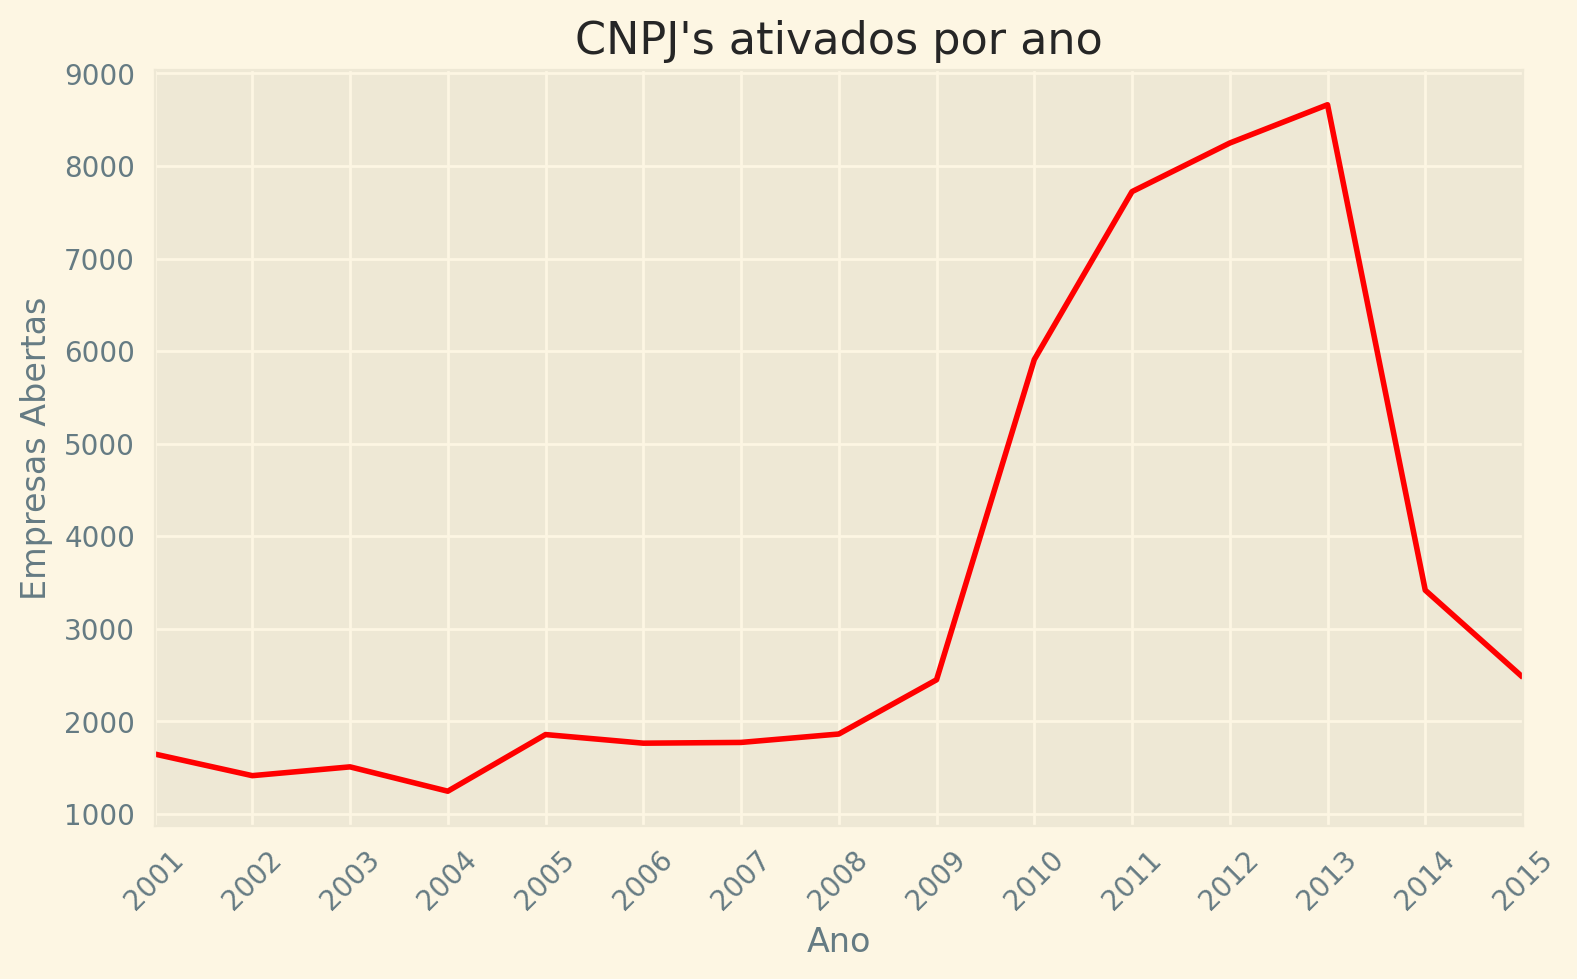

,Medidas
count,15.00
mean,3462.60
std,2715.31
min,1244.00
25%,1704.50
50%,1862.00
75%,4662.00
max,8662.00


In [48]:
def open_by_year():
    # Filter out rows where 'situacao_cadastral' is not equal to 2
    p1 = empresas_pi

    # Convert 'data_situacao_cadastral' to datetime
    p1['data_inicio_atividade'] = pd.to_datetime(p1['data_inicio_atividade'])

    # Extract year and quarter from 'data_situacao_cadastral'
    p1['ano_inicio'] = p1['data_inicio_atividade'].dt.year

    # Count occurrences for each 'ano_atividade'
    p1 = p1.groupby('ano_inicio').size().reset_index(name='count')

    # Create the line plot using Seaborn
    
   
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=p1, x='ano_inicio', y='count', color='red', linewidth=2)

    # Adjust plot labels and styles
    plt.title("CNPJ's ativados por ano")
    plt.xlabel("Ano")
    plt.ylabel("Empresas Abertas")

    # Set x-axis breaks and labels
    plt.xticks(rotation=45)
    plt.xlim(2001, 2015)
    plt.xticks(range(2001, 2016, 1))

    # Show the plot
    plt.tight_layout()
    plt.show()

    return(p1['count'].describe().round(2).to_frame('Medidas'))


open_by_year()

## Baixa de CNPJ por ano

Inicialmente, o gráfico de encerramento de CNPJs por ano mostra um comportamento com variação mínima. No entanto, a partir de 2012, observa-se um aumento considerável nos números. É importante destacar a presença de dois picos nos anos de 2015 e 2018. Durante a análise, notamos que existem alguns dias com um número elevado de encerramentos, conforme observado.

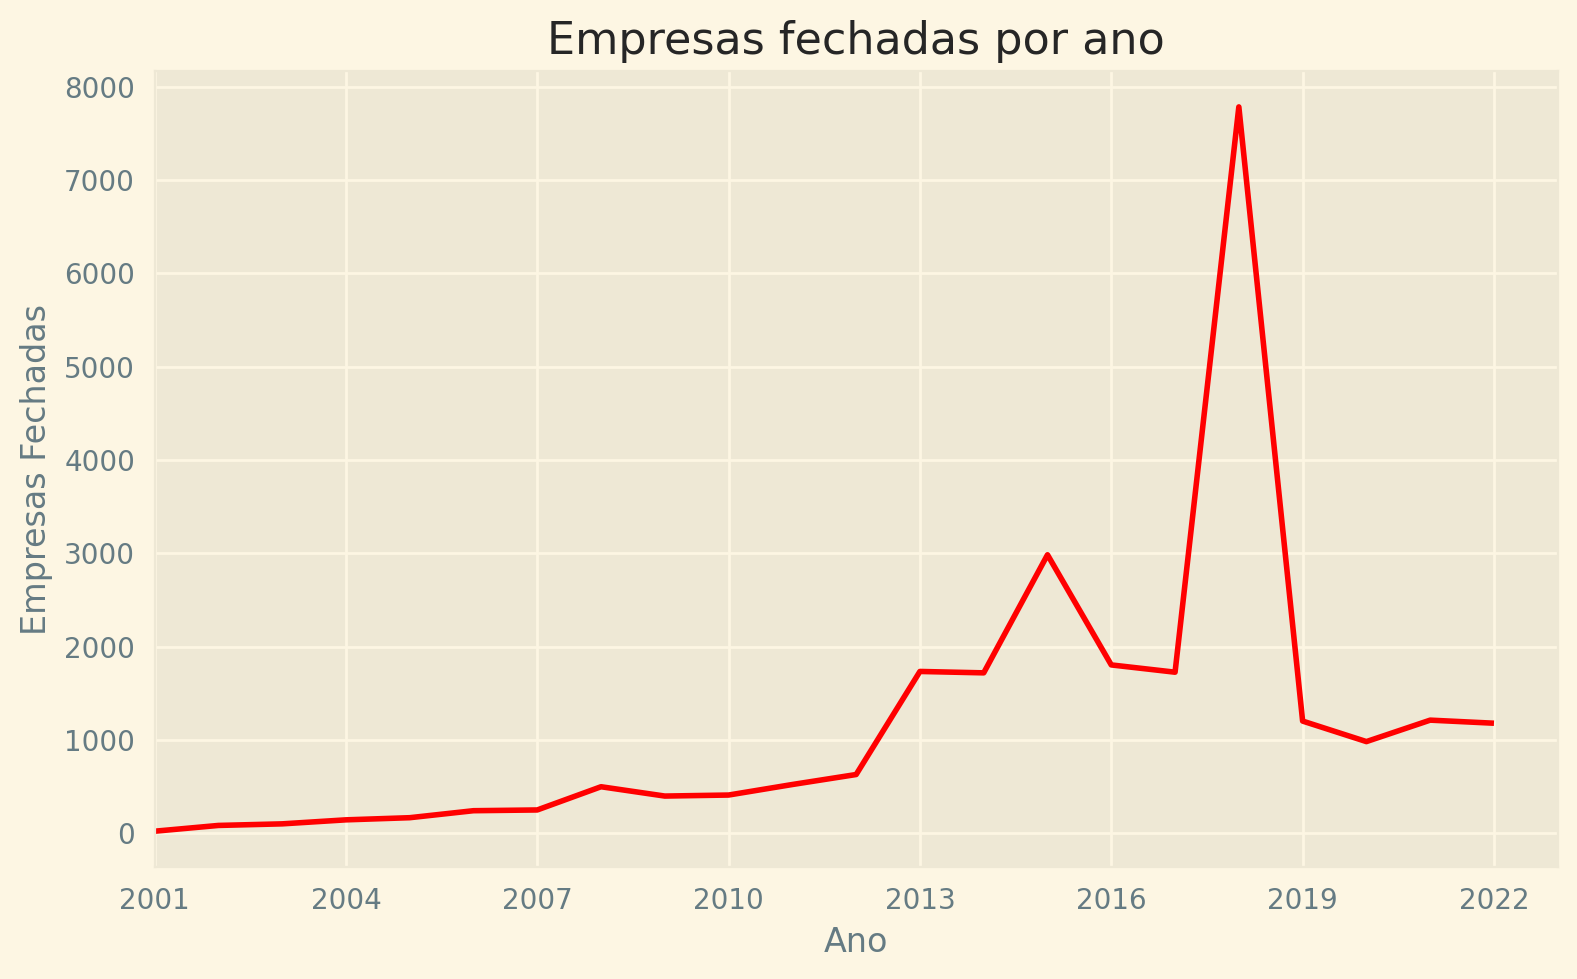

In [49]:
def close_by_year():
    # Filter out rows where 'situacao_cadastral' is not equal to 2
    p1 = empresas_pi[empresas_pi['situacao_cadastral'] != 2]

    # Convert 'data_situacao_cadastral' to datetime
    p1['data_situacao_cadastral'] = pd.to_datetime(p1['data_situacao_cadastral'])

    # Extract year and quarter from 'data_situacao_cadastral'
    p1['ano_atividade'] = p1['data_situacao_cadastral'].dt.year
    p1['mes_atividade'] = p1['data_situacao_cadastral'].dt.year

    # Count occurrences for each 'ano_atividade'
    p1 = p1.groupby('ano_atividade').size().reset_index(name='count')

    # Create the line plot using Seaborn
    
   
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=p1, x='ano_atividade', y='count', color='red', linewidth=2)

    # Adjust plot labels and styles
    plt.title("Empresas fechadas por ano")
    plt.xlabel("Ano")
    plt.ylabel("Empresas Fechadas")

    # Set x-axis breaks and labels
    plt.xlim(2001, 2023)
    plt.xticks(range(2001, 2024, 3))

    # Show the plot
    plt.tight_layout()
    plt.show()

close_by_year()

### Dias diferentes

É importante aprofundar o conceito de censura. Refere-se à situação em que a informação sobre o tempo de ocorrência do evento de interesse não está disponível para todos os indivíduos do estudo. Em vez disso, para alguns indivíduos, só sabemos que o evento não ocorreu até um certo ponto no tempo.

 No caso das empresas analisadas que ainda não tiveram a baixa no CNPJ, houve uma censura à esquerda, já que o encerramento do CNPJ ocorreu após a data limite desta pesquisa, em 31/12/2015. No entanto, há situações em que as empresas poderiam ter encerrado o CNPJ antes do início da pesquisa, o que seria considerado censura à direita. Entretanto, esse cenário não se aplica a esta pesquisa, pois utilizamos todas as informações disponíveis no banco de dados, tendo determinado o período de tempo abrangido.

Outro tipo de censura consiste na *intervalar*, devido o tempo real não ter sido registrado, mas pertencente a um intervalo de tempo da pesquisa.

In [6]:
def days_anormal():
    p1 = empresas_pi[empresas_pi['situacao_cadastral'] == 8]

    # Group by 'data_situacao_cadastral' and count occurrences
    p1 = p1.groupby('data_situacao_cadastral').size().reset_index(name='Quantidade')

    # Sort by 'Quantidade' in descending order
    p1 = p1.sort_values(by='Quantidade', ascending=False)

    # Rename columns
    p1 = p1.rename(columns={'data_situacao_cadastral': 'Data situação cadastral'})
    p1 = p1[p1['Quantidade'] > 50]
    return p1

days_anormal()

,Data situação cadastral,Quantidade
3172,2018-02-01,6410
2298,2015-02-09,1307
874,2008-12-31,148



Nos 2 primeiros registros, observamos uma quantidade de encerramentos que fogem do padrão. Isso se deve a iniciativas da Receita Federal para desativar registros de empresas que já não estavam em operação, mas não tinham formalizado o encerramento. Para corrigir essas discrepâncias, houve uma extensa atualização dos dados dessas empresas nesses dois dias específicos. Nesse período, a Receita Federal desativou vários CNPJs, pois as empresas já não estavam em funcionamento.

Nos dias em questão, vivenciamos uma situação atípica, pois a instituição federal efetuou o encerramento dos CNPJs por uma medida legal em 2018 e 2015. O procedimento padrão envolve uma solicitação de encerramento que, quando comprovada a quitação das obrigações legais, resulta na efetivação do encerramento. Para os propósitos desta pesquisa, todas as baixas ocorridas nesses dois dias serão tratadas como censura intervalar, visto que, mesmo com a data de encerramento registrada, os eventos indicam um processo diferenciado.


## Duração do CNPJ ativo

Analisando apenas os CNPJs que tiveram encerramento registrados, observamos que a maioria das baixas ocorre até 8 anos após a ativação. No nono ano, há uma redução próxima a 50%. Os dados revelam um período ativo médio de 5,92 anos, com uma mediana próxima a esse valor, marcando 5,51. Notamos que 75% dos registros permanecem ativos por até 7,75 anos. O período mais longo registrado é de 21,55 anos, indicando que uma empresa aberta em 2001 teve seu CNPJ encerrado em 2022.

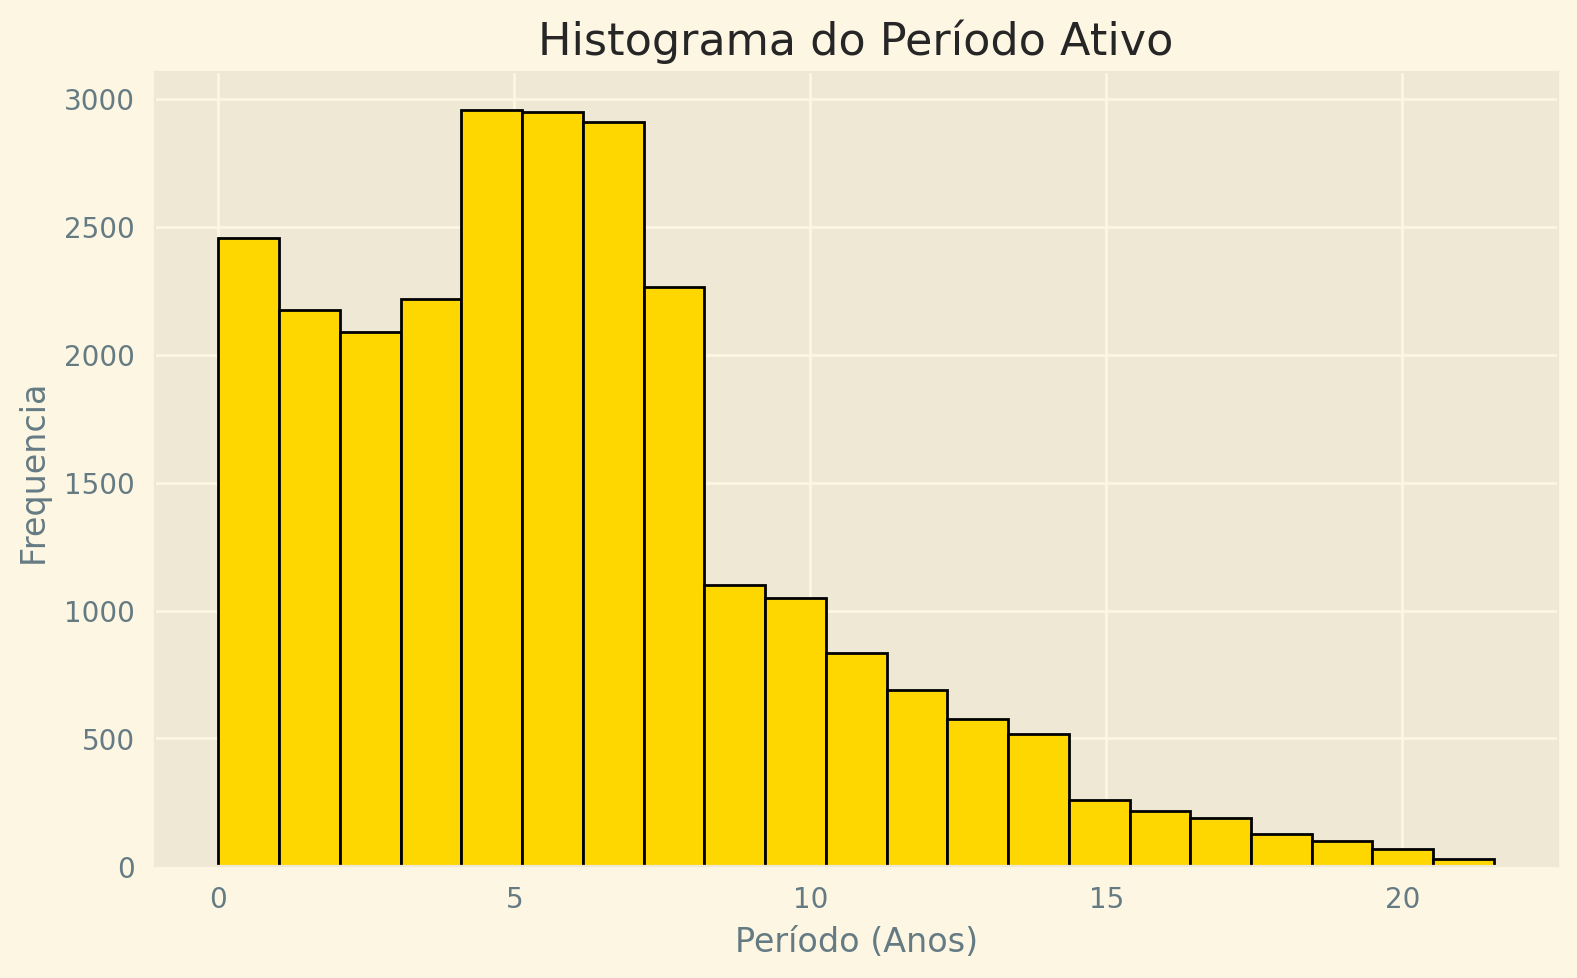

,Medidas
count,25767.00
mean,5.92
std,4.00
min,0.00
25%,2.96
50%,5.51
75%,7.76
max,21.55


In [50]:
def duration():
    empresas_pi1 = empresas_pi[empresas_pi['situacao_cadastral'] != 2]
    plt.figure(figsize=(8, 5))
    plt.hist(empresas_pi1['Período'], bins=int(empresas_pi1['Período'].max()), color='gold', edgecolor='black')
    plt.xlabel('Período (Anos)')
    plt.ylabel('Frequencia ')
    plt.title('Histograma do Período Ativo')
    plt.tight_layout()
    plt.show()

    return(empresas_pi1['Período'].describe().round(2).to_frame('Medidas'))

duration()

## Onde estão os CNPJ?

O estado do Piauí é uma unidade federativa com um polo econômico significativo em toda a sua extensão. A capital, Teresina, concentra 46% dos CNPJs cadastrados, enquanto os 54% restantes são distribuídos entre os outros 223 municípios. A capital se destaca de forma notável e, em algumas pesquisas, pode necessitar de uma abordagem isolada devido à discrepância nos números em comparação com o total de todas as cidades do interior.

In [8]:
# Filtering and aggregation
dates_pi = (
    empresas_pi[empresas_pi['situacao_cadastral'] == 8]
    .groupby('name_muni')
    .size()
    .reset_index(name='Quantidade')
    .assign(Percentual=lambda x: x['Quantidade'] / x['Quantidade'].sum() * 100)
    .filter(items=['name_muni', 'Quantidade', 'Percentual'])
    .sort_values(by='Quantidade', ascending=False)
    .rename(columns={'name_muni': 'Município'})
    .head(15)
)

dates_pi['Percentual'] = dates_pi['Percentual'].round(2)
dates_pi


,Município,Quantidade,Percentual
214,Teresina,11734,45.54
150,Parnaíba,1720,6.68
158,Picos,1043,4.05
81,Floriano,862,3.35
45,Campo Maior,623,2.42
162,Piripiri,559,2.17
211,São Raimundo Nonato,324,1.26
29,Bom Jesus,319,1.24
141,Oeiras,297,1.15
105,José De Freitas,264,1.02


Teresina representou 45,54% das empresas fechadas, seguida por Parnaíba, com 6,68%. Ao examinarmos a tabela, notamos que apenas as onze primeiras cidades superam 1% do total de empresas com encerramento de registro.

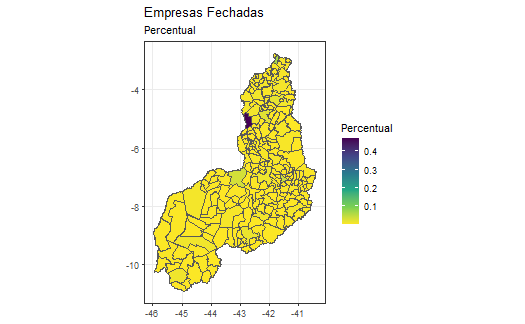

In [9]:
Image(filename="./000010.png", width=800)

## Quais as atividades dos CNPJ's?


As informações apresentadas anteriormente consideram todas as empresas reunidas, sem distinção. No Brasil, existe o CNAE - Classificação Nacional de Atividades Econômicas - que define a área de atuação da atividade empresarial, ou seja, é um código que agrupa um conjunto de atividades realizadas pela empresa. Conforme observado na tabela a seguir, o ramo mais comum no Piauí é o de "Comércio Varejista", com 43,67%. Em segundo lugar, temos o ramo alimentício, representando 6,55% do total.


In [10]:
# Filter out rows where 'nm_classe' is not NaN
empresas_pi = empresas_pi.dropna(subset=['nm_classe'])


df_divisao = (empresas_pi
    .groupby('nm_divisao')
    .size()
    .reset_index(name = 'Quantidade')
    .assign(Percentual=lambda x: x['Quantidade'] / x['Quantidade'].sum() * 100)
    .sort_values(by='Quantidade', ascending=False)
    .head(20)
    )

df_divisao['Percentual'] = df_divisao['Percentual'].round(2)
df_divisao

,nm_divisao,Quantidade,Percentual
30,COMÉRCIO VAREJISTA,22680,43.67
3,ALIMENTAÇÃO,3401,6.55
28,COMÉRCIO E REPARAÇÃO DE VEÍCULOS AUTOMOTORES E MOTOCICLETAS,3144,6.05
64,OUTRAS ATIVIDADES DE SERVIÇOS PESSOAIS,2552,4.91
29,COMÉRCIO POR ATACADO EXCETO VEÍCULOS AUTOMOTORES E MOTOCICLETAS,1795,3.46
83,TRANSPORTE TERRESTRE,1428,2.75
78,SERVIÇOS ESPECIALIZADOS PARA CONSTRUÇÃO,1392,2.68
11,ATIVIDADES DE ATENÇÃO À SAÚDE HUMANA,1372,2.64
76,SERVIÇOS DE ESCRITÓRIO DE APOIO ADMINISTRATIVO E OUTROS SERVIÇOS PRESTADOS PRINCIPALMENTE ÀS EMPRESAS,1297,2.50
31,CONFECÇÃO DE ARTIGOS DO VESTUÁRIO E ACESSÓRIOS,1250,2.41


### Mais detalhes do tipo Comercio Varejista

"Comércio Varejista" é um termo bastante abrangente e, para uma compreensão mais precisa sobre quais tipos de comércios estão sendo afetados, realizamos uma análise específica para esse setor. Observa-se que o ramo de confecções é o mais frequente, seguido por estabelecimentos que lidam com alimentos ou pequenas mercearias.

In [11]:
df_classe = (empresas_pi[empresas_pi['nm_divisao'] == 'COMÉRCIO VAREJISTA']
    .groupby('nm_classe')
    .size()
    .reset_index(name = 'Quantidade')
    .assign(Percentual=lambda x: x['Quantidade'] / x['Quantidade'].sum() * 100)
    .sort_values(by='Quantidade', ascending=False)
    .head(20)
    )

df_classe['Percentual'] = df_classe['Percentual'].round(2)
df_classe

,nm_classe,Quantidade,Percentual
2,Comércio varejista de artigos do vestuário e acessórios,5014,22.11
20,Comércio varejista de mercadorias em geral com predominância de produtos alimentícios - minimercados mercearias e armazéns,4089,18.03
12,Comércio varejista de ferragens madeira e materiais de construção,1786,7.87
34,Comércio varejista especializado de tecidos e artigos de cama mesa e banho,1303,5.75
25,Comércio varejista de produtos farmacêuticos para uso humano e veterinário,1048,4.62
22,Comércio varejista de outros produtos novos não especificados anteriormente,974,4.29
10,Comércio varejista de cosméticos produtos de perfumaria e de higiene pessoal,941,4.15
23,Comércio varejista de produtos alimentícios em geral ou especializado em produtos alimentícios não especificados anteriormente produtos do fumo,665,2.93
6,Comércio varejista de bebidas,649,2.86
8,Comércio varejista de carnes e pescados - açougues e peixarias,504,2.22


# Modelos de Kaplan-Meier - Geral

Após apresentar algumas informações sobre os dados coletados, pode-se iniciar a análise de sobrevivência do período ativo dos CNPJ's. Num primeiro momento, iremos analisar de forma geral, ou seja, a curva de sobrevivência de todas as entidades empresariais registradas entre 2001 e 2015

Um dado importante é a proporção entre os dados censurados e os dados falhos. Observa-se uma divisão de 50/50 nos dados.

In [12]:
# identifying censorship
empresas_pi['Censura'] = np.where((empresas_pi['situacao_cadastral'] == 8)|
                                  (empresas_pi['data_situacao_cadastral']  == '2018-02-01')|
                                  (empresas_pi['data_situacao_cadastral']  == '2015-02-09'), 1, 0)   

# count of the failures and censorship
def table_cenrura():
    df_censura = (empresas_pi['Censura']
                            .value_counts()
                            .to_frame()
                            .rename(columns={'count': 'Quantidade'})
                            .assign(Percentual=lambda x: x['Quantidade'] / x['Quantidade'].sum() * 100))

    df_censura['Percentual'] = df_censura['Percentual'].round(2)
    return df_censura

table_cenrura()

,Quantidade,Percentual
Censura,,
0,26165,50.38
1,25774,49.62


A linha indica um comportamento linear na curva de sobrevivência, com uma proporção próxima de que a cada 5 anos, a chance de sobrevivência diminui em cerca de 20%. É importante destacar que a linha não atinge o eixo dos anos, permanecendo entre 0 e 20%. Isso se deve à presença contínua de entidades empresariais deste período com o CNPJ ativo, o que corresponde a 12,5% do total. Em outras palavras, 90% das entidades empresariais encerraram suas atividades e deram baixa no CNPJ.

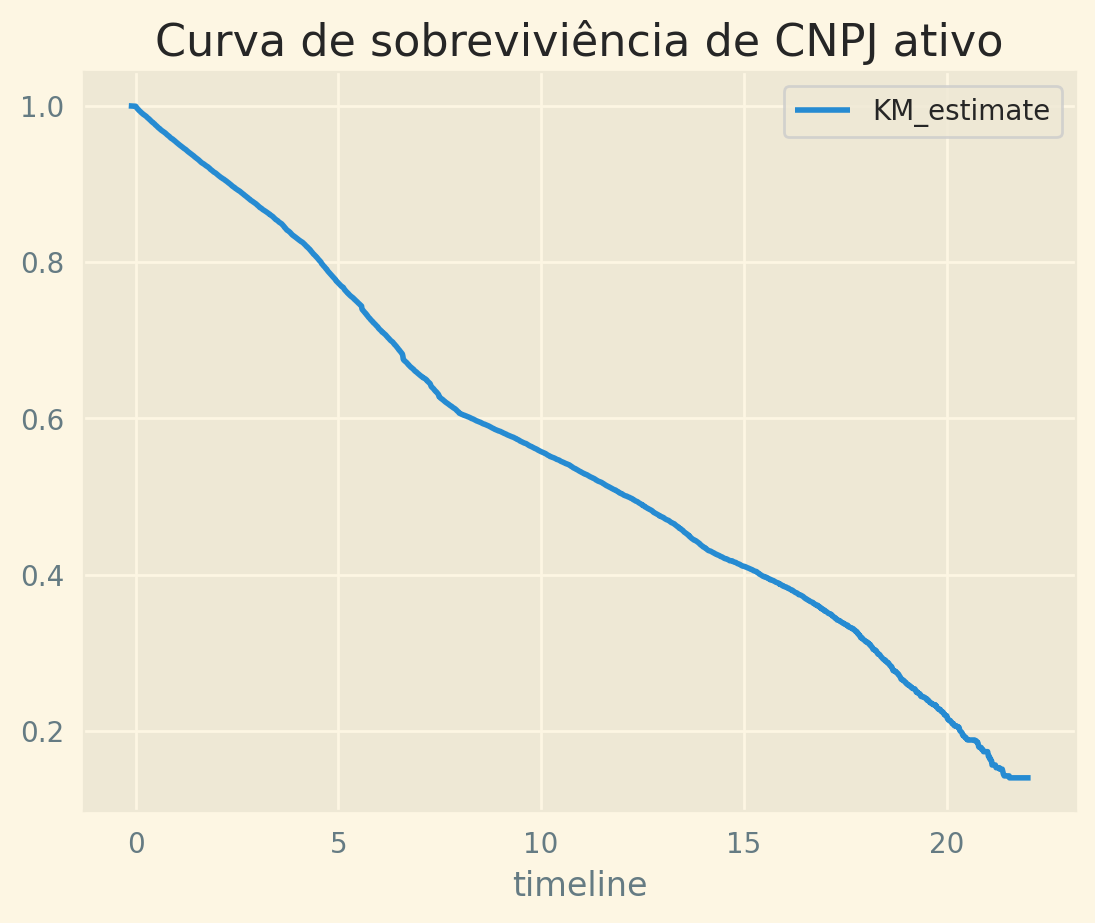

In [51]:
# survive analyses
kmf = KaplanMeierFitter()
kmf.fit(empresas_pi['Período'], event_observed = empresas_pi['Censura'])

kmf.survival_function_.plot()
plt.title('Curva de sobreviviência de CNPJ ativo')
plt.show()

Temos também que o tempo mediano dos dados está em 12,13 anos.

In [14]:
kmf.median_survival_time_

12.13

## Distinção Capital e Interior

In [15]:
# create a distinction 'capital' and 'interior'
empresas_pi['Região'] = np.where(empresas_pi['name_muni'] == 'Teresina', 'Capital', 'Interior')
empresas_pi['Região'].value_counts().to_frame().rename(columns={'count': 'Quantidade'}).assign(Percentual=lambda x: x['Quantidade'] / x['Quantidade'].sum() * 100)

,Quantidade,Percentual
Região,,
Interior,28911,55.663374
Capital,23028,44.336626


Entre as variáveis consideradas, a localização da empresa desempenha um papel crucial. Para esta análise, optou-se por distinguir entre estabelecimentos na capital e no interior. Teresina, sendo um polo econômico, abriga 45% do total de empresas. As curvas de sobrevivência revelam padrões distintos para os CNPJ's da capital e do interior, com pontos de interseção.

Do ponto de vista estatístico, é essencial empregar um teste que avalie a diferença de comportamento. Neste contexto, o teste de Log-Rank foi utilizado para determinar se existe uma discrepância estatisticamente significativa entre as distribuições de sobrevivência dos grupos em análise.

- $H_{0}$: não há diferença entre as curvas de sobrevivência dos grupos
- $H_{1}$: há diferença entre as curvas de sobrevivência dos grupos


Realizado o teste, há evidências significativas para rejeitar a hipótese nula, indicando diferenças entre as curvas.

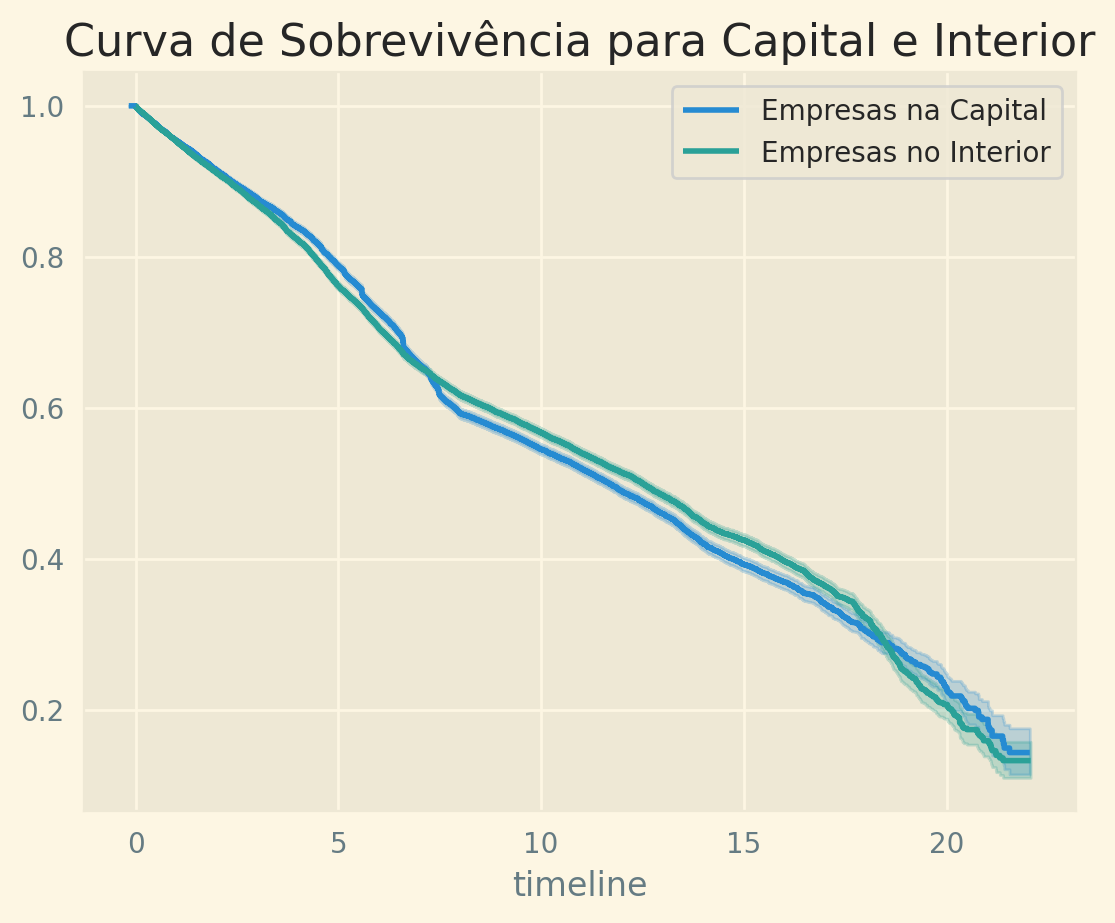

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.18 <0.005      9.46

In [52]:
def curve_s():
    ax = plt.subplot()

    region = (empresas_pi['Região'] == 'Capital')

    T = empresas_pi["Período"]
    E = empresas_pi["Censura"]

    kmf.fit(T[region], event_observed=E[region], label="Empresas na Capital")
    kmf.plot_survival_function(ax=ax)

    kmf.fit(T[~region], event_observed=E[~region], label="Empresas no Interior")
    kmf.plot_survival_function(ax=ax)

    plt.title("Curva de Sobrevivência para Capital e Interior")

    plt.show()

    results = logrank_test(T[region], T[~region], E[region], E[~region], alpha=.95)

    results.print_summary()

curve_s()

## Análise para um tipo específico de atividade de econômica: Comércio varejista de artigos do vestuário e acessórios

In [36]:
def table_vestuario():
    df_vestuario = empresas_pi[empresas_pi['nm_classe'] == 'Comércio varejista de artigos do vestuário e acessórios']

    df_vestuario = df_vestuario[['Período', 'Censura', 'capital_social', 'Região']]

    # df_vestuario['Região'] = np.where(df_vestuario['Região'] == 'Capital',2, 1)

    df_vestuario = df_vestuario[df_vestuario['Período'] > 0]

    return df_vestuario

df_vestuario = table_vestuario()
df_vestuario

,Período,Censura,capital_social,Região
127380,6.58,1,1.0,Interior
127381,0.89,1,1.0,Capital
127383,11.62,0,10000.0,Interior
127384,7.50,1,1.0,Capital
127385,6.58,1,1.0,Capital
...,...,...,...,...
137481,6.01,1,50000.0,Interior
137483,2.63,1,10000.0,Interior
137484,5.56,0,7000.0,Capital
137486,0.28,1,25000.0,Interior


Comentamos inicialmente que o banco de dados ofereceu somente três variáveis para análise. Após algumas análises, foi verificando que o capital social prejudicava mais do que ajudava a análise e a variável Região, após a utilização do teste de logrank, indicou uma diferença nas linhas de sobrevivência entre as empresas da capital e interior.

A variável mais importante consiste no tipo de comercio da entidade empresarial, onde a tabela possui 483 tipos diferentes de empreendimentos. Iremos apresentar somente para o tipo mais frequente, **Comércio varejista de artigos do vestuário e acessórios**, para outros tipos de atividade empresariais pode ser encontrado no seguinte link:

gn03e6-filipe-costa.shinyapps.io/shiny_survive_pi/


O que se percebe é consiste na curva de sobrevivência não difere muito da que considera todos os tipos de comercios tendo um comportamento semelhante. Os valores mudam para este tipo de atividade econômica, temos que a mediana está em 7,65 anos e que somente 8 % das empresas ainda possuem CNPJ ativo.

Text(0.5, 1.0, 'Curva de sobreviviência de "CNPJ ativo para "Comércio varejista de artigos do vestuário e acessórios"')

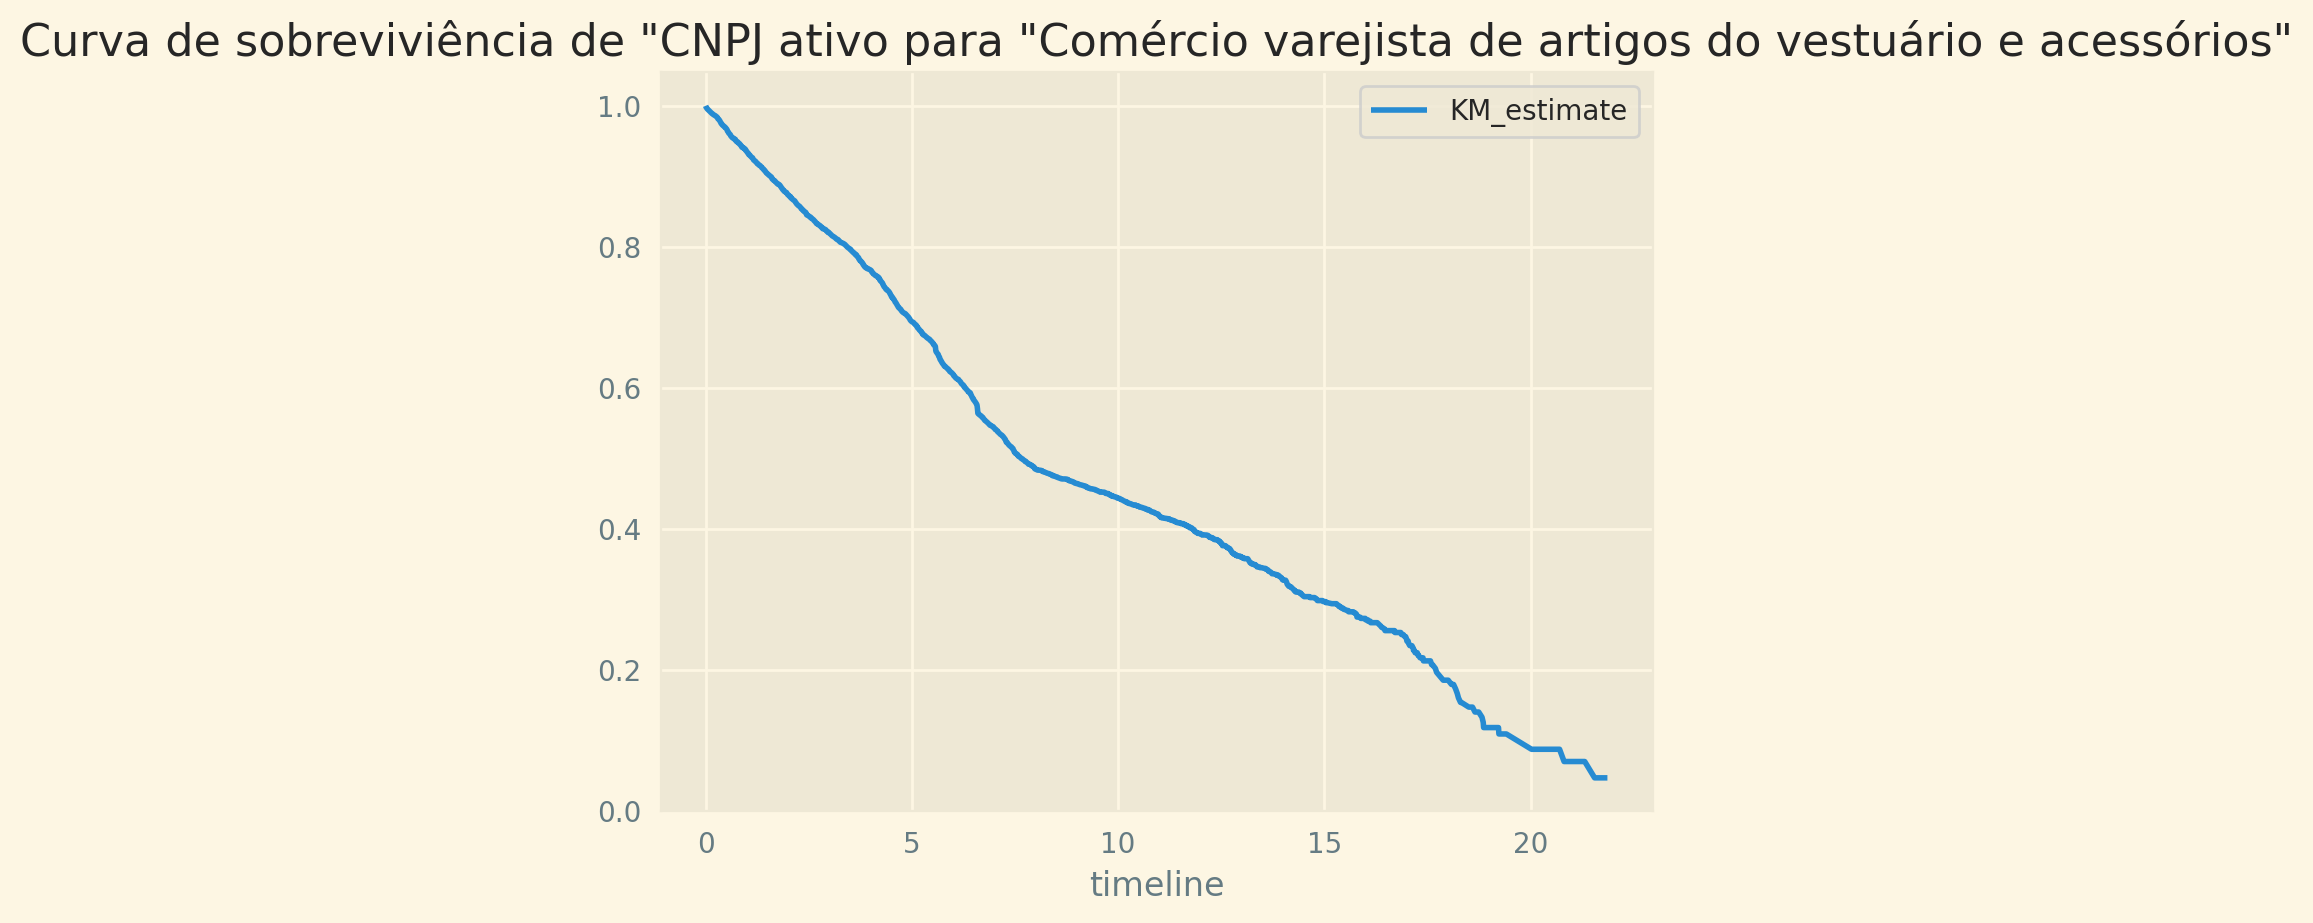

In [54]:
kmf_vestuario = KaplanMeierFitter()
kmf_vestuario.fit(df_vestuario['Período'], event_observed = df_vestuario['Censura'])

kmf_vestuario.survival_function_.plot()
plt.title('Curva de sobreviviência de "CNPJ ativo para "Comércio varejista de artigos do vestuário e acessórios"')

In [38]:
kmf_vestuario.median_survival_time_

7.65

Através do gráfico que mostra a curva para o interior e para a capital, vemos a curva até 7 anos se mantem juntas. A partir de 7 anos, percebe-se que as empresas na capitais possuem uma redução maior na curva de sobrevivência, o que indica um tempo de CNPJ menor comparada as empresas do interior.  

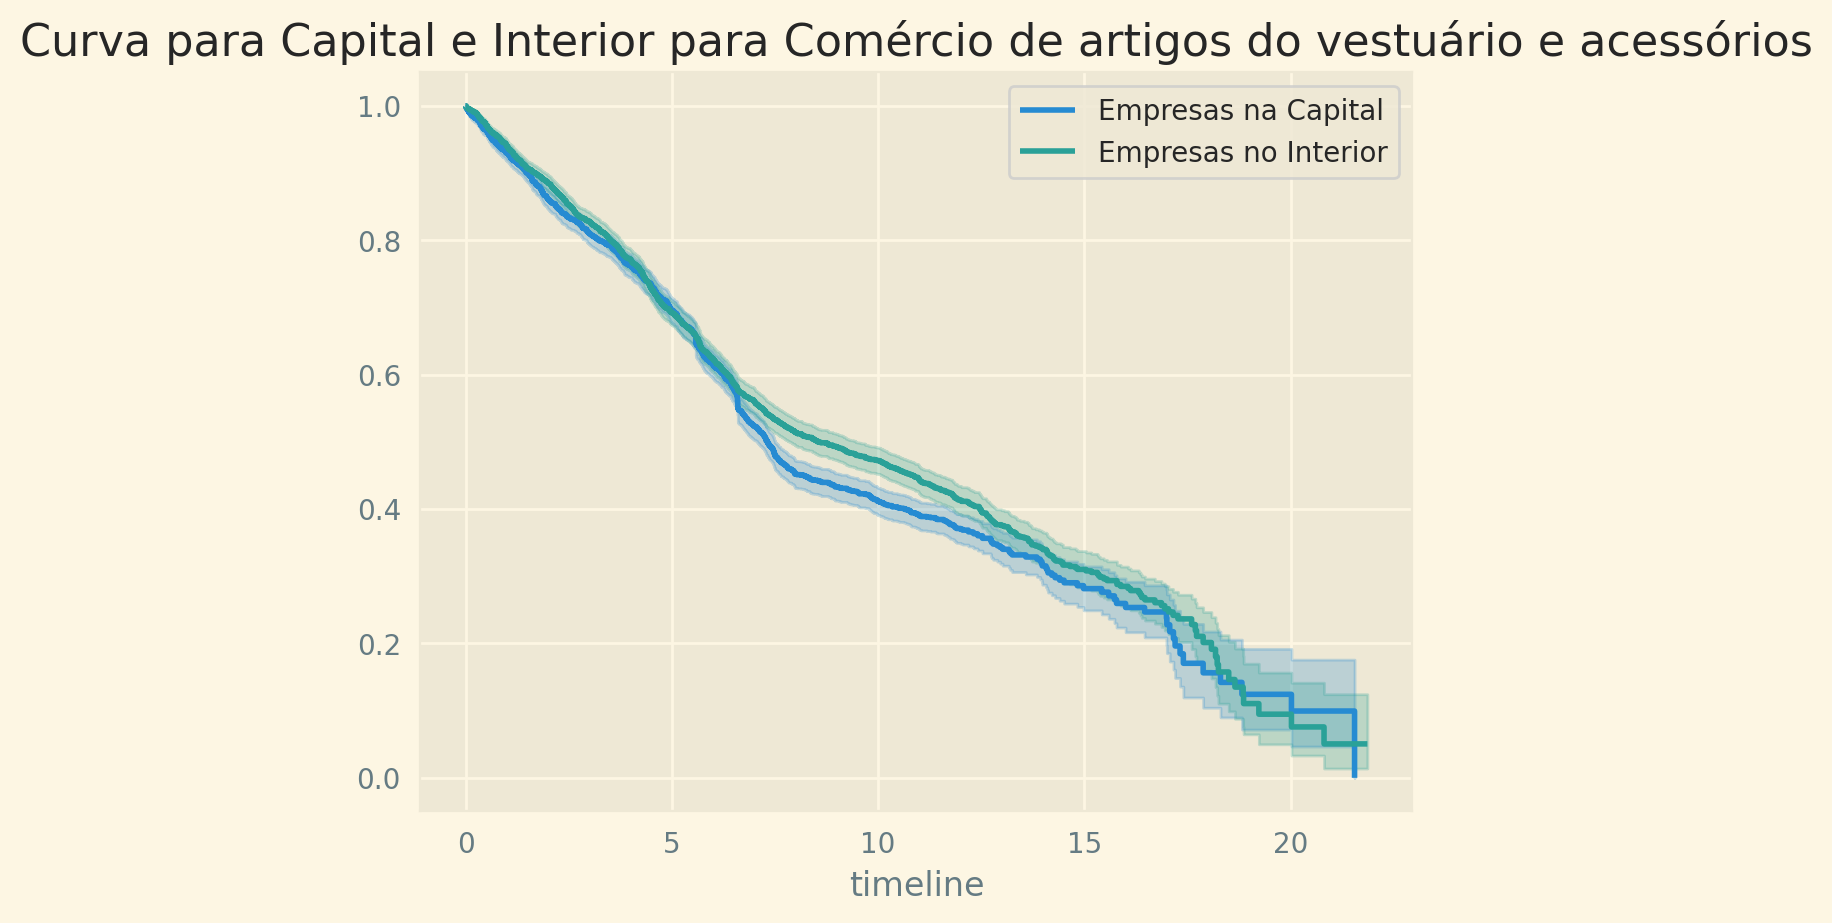

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           8.73 <0.005      8.32

In [47]:
def curve_v():
    ax = plt.subplot()

    region_v = (df_vestuario['Região'] == 'Capital')

    Tv = df_vestuario["Período"]
    Ev = df_vestuario["Censura"]

    kmf.fit(Tv[region_v], event_observed=Ev[region_v], label="Empresas na Capital")
    kmf.plot_survival_function(ax=ax)

    kmf.fit(Tv[~region_v], event_observed=Ev[~region_v], label="Empresas no Interior")
    kmf.plot_survival_function(ax=ax)

    plt.title("Curva para Capital e Interior para Comércio de artigos do vestuário e acessórios")

    plt.show()

    results = logrank_test(Tv[region_v], Tv[~region_v], Ev[region_v], Ev[~region_v], alpha=.95)

    results.print_summary()

curve_v()